Agave on Python

In [1]:
!mkdir -p ~/agave

%cd ~/agave

!pip3 install --upgrade setvar

import re
import os
import sys
from setvar import *
from time import sleep

# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
loadvar()

/home/jovyan/agave
Requirement already up-to-date: setvar in /opt/conda/lib/python3.6/site-packages
MACHINE_IP=149.165.157.140
MACHINE_NAME=jetstream
DOMAIN=jetstream-cloud.org
EMAIL=sbrandt@cct.lsu.edu
AGAVE_USERNAME=stevenrbrandt
MACHINE_USERNAME=jovyan
BASE_APP_NAME=funwave-tvd
PORT=10022
DOCKERHUB_NAME=stevenrbrandt
WORK_DIR=/home/jovyan
HOME_DIR=/home/jovyan
SCRATCH_DIR=/home/jovyan
DEPLOYMENT_PATH=agave-deployment
PATH=/home/jovyan/agave/cli/bin:/opt/conda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/jq/bin:/home/jovyan/src/cli/bin
EXEC_MACHINE=jetstream-exec-stevenrbrandt
AGAVE_JSON_PARSER=jq
APP_NAME=funwave-tvd-jetstream-stevenrbrandt
STORAGE_MACHINE=jetstream-storage-stevenrbrandt
REMOTE_COMMAND=docker build --rm -t funwave-tvd .
IN_FILE=agave://jetstream-storage-stevenrbrandt/funwave-tvd-docker/Dockerfile
PBTOK=.....
AGAVE_PASSWD=.....
JOB_ID=4151880429225775591-242ac11b-0001-007
STAT=FINISHED
CMD=jobs-output-get 4151880429225775

In [2]:
writefile("input.txt","""
!INPUT FILE FOR FUNWAVE_TVD
  ! NOTE: all input parameter are capital sensitive
  ! --------------------TITLE-------------------------------------
  ! title only for log file
TITLE = VESSEL
  ! -------------------HOT START---------------------------------
HOT_START = F
FileNumber_HOTSTART = 1
  ! -------------------PARALLEL INFO-----------------------------
  ! 
  !    PX,PY - processor numbers in X and Y
  !    NOTE: make sure consistency with mpirun -np n (px*py)
  !    
PX = 4
PY = 1
  ! --------------------DEPTH-------------------------------------
  ! Depth types, DEPTH_TYPE=DATA: from depth file
  !              DEPTH_TYPE=FLAT: idealized flat, need depth_flat
  !              DEPTH_TYPE=SLOPE: idealized slope, 
  !                                 need slope,SLP starting point, Xslp
  !                                 and depth_flat
DEPTH_TYPE = FLAT
DEPTH_FLAT = 10.0
  ! -------------------PRINT---------------------------------
  ! PRINT*,
  ! result folder
RESULT_FOLDER = output/

  ! ------------------DIMENSION-----------------------------
  ! global grid dimension
Mglob = 500
Nglob = 100

  ! ----------------- TIME----------------------------------
  ! time: total computational time/ plot time / screen interval 
  ! all in seconds
TOTAL_TIME = 10.0
PLOT_INTV = 1.0
PLOT_INTV_STATION = 50000.0
SCREEN_INTV = 1.0
HOTSTART_INTV = 360000000000.0

  ! -----------------GRID----------------------------------
  ! if use spherical grid, in decimal degrees
  ! cartesian grid sizes
DX = 1.0
DY = 1.0
  ! ----------------SHIP WAKES ----------------------------
VESSEL_FOLDER = ./
NumVessel = 2
  ! -----------------OUTPUT-----------------------------
ETA = T
U = T
V = T
""")

Writing file `input.txt'


In [16]:
writefile("run.sh","""
#!/bin/bash
export LD_LIBRARY_PATH=/usr/local/lib
mkdir -p rundir
cd ./rundir
cp ../input.txt .
mpirun -np 4 ~/FUNWAVE-TVD/src/funwave_vessel
""")

Writing file `run.sh'


In [17]:
!scp -P 10022 input.txt run.sh $VM_IPADDRESS:.
!ssh -p 10022 $VM_IPADDRESS bash run.sh

input.txt                                     100% 1691     1.7KB/s   00:00    
run.sh                                        100%  141     0.1KB/s   00:00    
 BATHY_CORRECTION DOES NOT EXIST. USE DEFAULT VALUE
 INI_UVZ DOES NOT EXIST. USE DEFAULT VALUE
 WaterLevel DOES NOT EXIST. USE DEFAULT VALUE
 WAVEMAKER DOES NOT EXIST. USE DEFAULT VALUE
                            No WaveMaker
 ETA_LIMITER DOES NOT EXIST. USE DEFAULT VALUE
 EqualEnergy DOES NOT EXIST. USE DEFAULT VALUE
 PERIODIC DOES NOT EXIST. USE DEFAULT VALUE
 DIFFUSION_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 DIRECT_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 FRICTION_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 OBSTACLE_FILE DOES NOT EXIST. USE DEFAULT VALUE
 BREAKWATER_FILE DOES NOT EXIST. USE DEFAULT VALUE
 DISPERSION DOES NOT EXIST. USE DEFAULT VALUE
         DISPERSION Default:  DISPERSION
 Gamma1 DOES NOT EXIST. USE DEFAULT VALUE
        Gamma1 Default:  1.0: DISPERSION
 Gamma2 DOES NOT EXIST. USE DEFAULT VALUE
           

 Simulation takes   24.398454239002604      seconds
 Normal Termination!


In [18]:
!scp -q -r -P 10022 $VM_IPADDRESS:rundir/output .

In [19]:
!ls output

eta_00001  eta_00009  eta_00017  u_00004  u_00012  u_00020  v_00007  v_00015
eta_00002  eta_00010  eta_00018  u_00005  u_00013  u_00021  v_00008  v_00016
eta_00003  eta_00011  eta_00019  u_00006  u_00014  v_00001  v_00009  v_00017
eta_00004  eta_00012  eta_00020  u_00007  u_00015  v_00002  v_00010  v_00018
eta_00005  eta_00013  eta_00021  u_00008  u_00016  v_00003  v_00011  v_00019
eta_00006  eta_00014  u_00001	 u_00009  u_00017  v_00004  v_00012  v_00020
eta_00007  eta_00015  u_00002	 u_00010  u_00018  v_00005  v_00013  v_00021
eta_00008  eta_00016  u_00003	 u_00011  u_00019  v_00006  v_00014


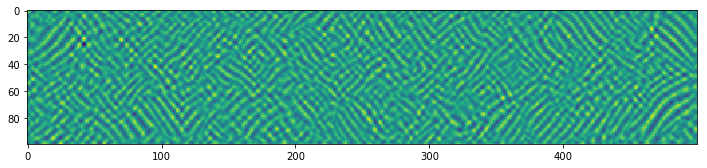

In [20]:
data = np.genfromtxt("output/eta_00010")
plt.figure(figsize=(12,12))
plt.imshow(data[::-1,:])
plt.show()

In [59]:
!mkdir funwave-tvd-docker
writefile("funwave-tvd-docker/Dockerfile","""
FROM stevenrbrandt/science-base

MAINTAINER Steven R. Brandt <sbrandt@cct.lsu.edu>
RUN cd && \
    git clone https://github.com/fengyanshi/FUNWAVE-TVD && \
    cd FUNWAVE-TVD/src && \
    perl -p -i -e 's/FLAG_8 = -DCOUPLING/#$&/' Makefile && \
    make

WORKDIR /home/jovyan/FUNWAVE-TVD/src
RUN mkdir -p /home/jovyan/FUNWAVE-TVD/rundir
WORKDIR /home/jovyan/FUNWAVE-TVD/rundir
USER root
COPY entrypoint.sh /usr/local/bin
RUN chmod 755 /usr/local/bin/entrypoint.sh
ENTRYPOINT ["/usr/local/bin/entrypoint.sh"]
""")

Writing file `funwave-tvd-docker/Dockerfile'


In [150]:
!rm -fr rundir
!mkdir -p rundir
!cp input.txt rundir/
!docker run -it --user 0 --rm -e USER_ID=$(id -u) -v ~/agave/FUNWAVE-TVD/src/rundir:/home/user funwave-tvd \
    'mpirun -np 4 /home/jovyan/FUNWAVE-TVD/src/funwave_vessel'

useradd: warning: the home directory already exists.
Not copying any file from skel directory into it.
ARGS: mpirun -np 4 /home/jovyan/FUNWAVE-TVD/src/funwave_vessel
uid=0(root) gid=0(root) groups=0(root)
 BATHY_CORRECTION DOES NOT EXIST. USE DEFAULT VALUE
 INI_UVZ DOES NOT EXIST. USE DEFAULT VALUE
 WaterLevel DOES NOT EXIST. USE DEFAULT VALUE
 WAVEMAKER DOES NOT EXIST. USE DEFAULT VALUE
                            No WaveMaker
 ETA_LIMITER DOES NOT EXIST. USE DEFAULT VALUE
 EqualEnergy DOES NOT EXIST. USE DEFAULT VALUE
 PERIODIC DOES NOT EXIST. USE DEFAULT VALUE
 DIFFUSION_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 DIRECT_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 FRICTION_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 OBSTACLE_FILE DOES NOT EXIST. USE DEFAULT VALUE
 BREAKWATER_FILE DOES NOT EXIST. USE DEFAULT VALUE
 DISPERSION DOES NOT EXIST. USE DEFAULT VALUE
         DISPERSION Default:  DISPERSION
 Gamma1 DOES NOT EXIST. USE DEFAULT VALUE
        Gamma1 Default:  1.0: DISPERSION
 Gamma2 

 ----------------- STATISTICS ----------------
  TIME        DT
  0.1101E+02  0.5048E-01
  MassVolume  Energy      MaxEta      MinEta      Max U       Max V 
  0.3805E-04  0.6131E+07  0.4489E-05 -0.4257E-05  0.7346E-06  0.7018E-06
  MaxTotalU   PhaseS      Froude 
  0.8436E-06  0.9905E+01  0.8518E-07
   PRINTING FILE NO.    12  TIME/TOTAL:       11.005 /      20.000
 ----------------- STATISTICS ----------------
  TIME        DT
  0.1201E+02  0.5048E-01
  MassVolume  Energy      MaxEta      MinEta      Max U       Max V 
  0.4118E-04  0.6131E+07  0.4569E-05 -0.3969E-05  0.7774E-06  0.7795E-06
  MaxTotalU   PhaseS      Froude 
  0.8925E-06  0.9905E+01  0.9011E-07
   PRINTING FILE NO.    13  TIME/TOTAL:       12.015 /      20.000
 ----------------- STATISTICS ----------------
  TIME        DT
  0.1302E+02  0.5048E-01
  MassVolume  Energy      MaxEta      MinEta      Max U       Max V 
  0.3310E-04  0.6131E+07  0.4973E-05 -0.4373E-05  0.7874E-06  0.7187E-06
  MaxTotalU   PhaseS      Froud

In [152]:
!ls rundir/output

eta_00001  eta_00009  eta_00017  u_00004  u_00012  u_00020  v_00007  v_00015
eta_00002  eta_00010  eta_00018  u_00005  u_00013  u_00021  v_00008  v_00016
eta_00003  eta_00011  eta_00019  u_00006  u_00014  v_00001  v_00009  v_00017
eta_00004  eta_00012  eta_00020  u_00007  u_00015  v_00002  v_00010  v_00018
eta_00005  eta_00013  eta_00021  u_00008  u_00016  v_00003  v_00011  v_00019
eta_00006  eta_00014  u_00001	 u_00009  u_00017  v_00004  v_00012  v_00020
eta_00007  eta_00015  u_00002	 u_00010  u_00018  v_00005  v_00013  v_00021
eta_00008  eta_00016  u_00003	 u_00011  u_00019  v_00006  v_00014


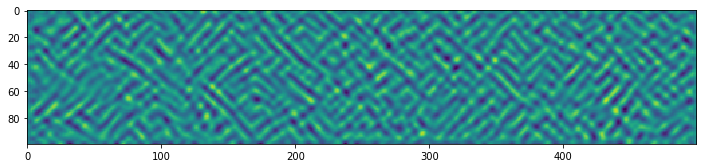

In [153]:
data = np.genfromtxt("rundir/output/u_00020")
plt.figure(figsize=(12,12))
plt.imshow(data[::-1,:])
plt.show()

In [56]:
!docker tag funwave-tvd ${DOCKERHUB_NAME}/funwave-tvd:latest
!docker push ${DOCKERHUB_NAME}/funwave-tvd:latest

The push refers to a repository [docker.io/stevenrbrandt/funwave-tvd]

d49a189c: Preparing 
8a286ded: Preparing 
1e229e2e: Preparing 
86f1bf68: Preparing 
9e555372: Preparing 
6917689e: Preparing 
47e71dc0: Preparing 
c2077cde: Preparing 
7a2a783b: Preparing 
c2077cde: Waiting g 
6917689e: Layer already exists latest: digest: sha256:345643dcedc267512a67f1f455d807cd08b2de0bf1dc401f1b644df81c341ccd size: 2611


In [7]:
%cd ~/agave

/home/jovyan/agave


In [67]:
!tenants-init -t agave.prod

You are now configured to interact with the APIs at https://public.agaveapi.co/


In [68]:
!clients-delete -u $AGAVE_USERNAME -p "$AGAVE_PASSWD" $APP_NAME

Successfully deleted client funwave-tvd-jetstream-stevenrbrandt


In [69]:
!clients-create -p "$AGAVE_PASSWD" -S -N $APP_NAME -u $AGAVE_USERNAME

Successfully created client funwave-tvd-jetstream-stevenrbrandt
key: iIBuPSqVbssJ7fPiMSGhffOTLVsa 
secret: S2Kfx7AP8zQ3tCxtadXIYA2u1bka


In [70]:
!auth-tokens-create -u $AGAVE_USERNAME -p "$AGAVE_PASSWD"

Token for agave.prod:stevenrbrandt successfully refreshed and cached for 14400 seconds
f84ad3dc69c42857e8e4107944e5cee2


In [10]:
!auth-tokens-refresh

Token for agave.prod:stevenrbrandt successfully refreshed and cached for 14400 seconds
9cb8f716348526f3c4f1a01882328b8e


In [71]:
!jsonpki --public ~/.ssh/id_rsa.pub > ~/.ssh/id_rsa.pub.txt
!jsonpki --private ~/.ssh/id_rsa > ~/.ssh/id_rsa.txt

In [3]:
os.environ["PUB_KEY"]=readfile("${HOME}/.ssh/id_rsa.pub.txt").strip()
os.environ["PRIV_KEY"]=readfile("${HOME}/.ssh/id_rsa.txt").strip()

Reading file `/home/jovyan/.ssh/id_rsa.pub.txt'
Reading file `/home/jovyan/.ssh/id_rsa.txt'


In [81]:
writefile("${STORAGE_MACHINE}.txt","""{
    "id": "${STORAGE_MACHINE}",
    "name": "${MACHINE_NAME} storage (${MACHINE_USERNAME})",
    "description": "The ${MACHINE_NAME} computer",
    "site": "${DOMAIN}",
    "type": "STORAGE",
    "storage": {
        "host": "${MACHINE_IP}",
        "port": ${PORT},
        "protocol": "SFTP",
        "rootDir": "/",
        "homeDir": "${HOME_DIR}",
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        }
    }
}
""")

Writing file `jetstream-storage-stevenrbrandt.txt'


In [82]:
!systems-addupdate -F ${STORAGE_MACHINE}.txt

Successfully added system jetstream-storage-stevenrbrandt


In [15]:
!files-list -S ${STORAGE_MACHINE} ./ | head -5

.
.bash_history
.bash_logout
.bashrc
.cache


In [85]:
# Edit any parts of this file that you know need to be changed for your machine.
writefile("${EXEC_MACHINE}.txt","""
{
    "id": "${EXEC_MACHINE}",
    "name": "${MACHINE_NAME} (${MACHINE_USERNAME})",
    "description": "The ${MACHINE_NAME} computer",
    "site": "${DOMAIN}",
    "public": false,
    "status": "UP",
    "type": "EXECUTION",
    "executionType": "CLI",
    "scheduler" : "FORK",
    "environment": null,
    "scratchDir" : "${SCRATCH_DIR}",
    "queues": [
        {
            "name": "none",
            "default": true,
            "maxJobs": 10,
            "maxUserJobs": 10,
            "maxNodes": 6,
            "maxProcessorsPerNode": 6,
            "minProcessorsPerNode": 1,
            "maxRequestedTime": "00:30:00"
        }
    ],
    "login": {
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        },
        "host": "${MACHINE_IP}",
        "port": ${PORT},
        "protocol": "SSH"
    },
    "maxSystemJobs": 50,
    "maxSystemJobsPerUser": 50,
    "storage": {
        "host": "${MACHINE_IP}",
        "port": ${PORT},
        "protocol": "SFTP",
        "rootDir": "/",
        "homeDir": "${HOME_DIR}",
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        }
    },
    "workDir": "${WORK_DIR}"
}""")

Writing file `jetstream-exec-stevenrbrandt.txt'


In [86]:
!systems-addupdate -F ${EXEC_MACHINE}.txt

Successfully added system jetstream-exec-stevenrbrandt


In [14]:
# Test to see if this worked...
!files-list -S ${EXEC_MACHINE} ./ | head -5

Unable to contact api server at https://public.agaveapi.co/files/v2/listings/system/jetstream-exec-stevenrbrandt/./



In [88]:
writefile("fork-wrapper.txt","""
#!/bin/bash
\${command}
""")

Writing file `fork-wrapper.txt'


In [89]:
!files-mkdir -S ${STORAGE_MACHINE} -N ${DEPLOYMENT_PATH}
!files-upload -F fork-wrapper.txt -S ${STORAGE_MACHINE} ${DEPLOYMENT_PATH}/

Successfully created folder agave-deployment
Uploading fork-wrapper.txt...
######################################################################## 100.0%


In [90]:
writefile("fork-test.txt","""
command=date
fork-wrapper.txt
""")

Writing file `fork-test.txt'


In [91]:
!files-mkdir -S ${STORAGE_MACHINE} -N ${DEPLOYMENT_PATH}
!files-upload -F fork-test.txt -S ${STORAGE_MACHINE} ${DEPLOYMENT_PATH}/

Successfully created folder agave-deployment
Uploading fork-test.txt...
######################################################################## 100.0%


In [192]:
writefile("fork-app.txt","""
{  
   "name":"${AGAVE_USERNAME}-${MACHINE_NAME}-fork",
   "version":"1.0",
   "label":"Runs a command",
   "shortDescription":"Runs a command",
   "longDescription":"",
   "deploymentSystem":"${STORAGE_MACHINE}",
   "deploymentPath":"${DEPLOYMENT_PATH}",
   "templatePath":"fork-wrapper.txt",
   "testPath":"fork-test.txt",
   "executionSystem":"${EXEC_MACHINE}",
   "executionType":"CLI",
   "parallelism":"SERIAL",
   "modules":[],
   "inputs":[
         {   
         "id":"datafile",
         "details":{  
            "label":"Data file",
            "description":"",
            "argument":null,
            "showArgument":false
         },
         "value":{  
            "default":"/dev/null",
            "order":0,
            "required":false,
            "validator":"",
            "visible":true
         }
      }   
   ],
   "parameters":[{
     "id" : "command",
     "value" : {
       "visible":true,
       "required":true,
       "type":"string",
       "order":0,
       "enquote":false,
       "default":"/bin/date",
       "validator":null
     },
     "details":{
         "label": "Command to run",
         "description": "This is the actual command you want to run. ex. df -h -d 1",
         "argument": null,
         "showArgument": false,
         "repeatArgument": false
     },
     "semantics":{
         "label": "Command to run",
         "description": "This is the actual command you want to run. ex. df -h -d 1",
         "argument": null,
         "showArgument": false,
         "repeatArgument": false
     }
   }],
   "outputs":[]
}
""")

Writing file `fork-app.txt'


In [193]:
!apps-addupdate -F fork-app.txt

Successfully added app stevenrbrandt-jetstream-fork-1.0


In [194]:
setvar("REMOTE_COMMAND=singularity create --size 2000 funwave-tvd.img && "+
       "singularity import funwave-tvd.img docker://stevenrbrandt/funwave-tvd:latest")

REMOTE_COMMAND=singularity create --size 2000 funwave-tvd.img && singularity import funwave-tvd.img docker://stevenrbrandt/funwave-tvd:latest


In [195]:
writefile("job.txt","""
 {
   "name":"fork-command-1",
   "appId": "${AGAVE_USERNAME}-${MACHINE_NAME}-fork-1.0",
   "executionSystem": "${EXEC_MACHINE}",
   "archive": false,
   "notifications": [
    {
      "url":"${EMAIL}",
      "event":"FINISHED",
      "persistent":false
    },
    {
      "url":"${EMAIL}",
      "event":"FAILED",
      "persistent":false
    },
    {
      "url":"https://www.cct.lsu.edu/~sbrandt/pushbullet.php?key=${PBTOK}&status=\${JOB_STATUS}:\${JOB_ID}",
      "event":"FINISHED",
      "persistent":"false"
    },
    {
      "url":"https://www.cct.lsu.edu/~sbrandt/pushbullet.php?key=${PBTOK}&status=\${JOB_STATUS}:\${JOB_ID}",
      "event":"FAILED",
      "persistent":"false"
    }
   ],
   "parameters": {
     "command":"echo hello"
   }
 }
""")

Writing file `job.txt'


In [196]:
setvar("""
# Capture the output of the job submit command
OUTPUT=$(jobs-submit -F job.txt)
# Parse out the job id from the output
JOB_ID=$(echo $OUTPUT | cut -d' ' -f4)
""")

OUTPUT=Successfully submitted job 6838548361689371111-242ac11b-0001-007
JOB_ID=6838548361689371111-242ac11b-0001-007


In [197]:
for iter in range(20):
    setvar("STAT=$(jobs-status $JOB_ID)")
    stat = os.environ["STAT"]
    sleep(5.0)
    if stat == "FINISHED" or stat == "FAILED":
        break

STAT=PENDING
STAT=PENDING
STAT=PENDING
STAT=STAGED
STAT=STAGED
STAT=SUBMITTING
STAT=SUBMITTING
STAT=RUNNING
STAT=FINISHED


In [199]:
!echo jobs-history ${JOB_ID}
!jobs-history ${JOB_ID}

jobs-history 6838548361689371111-242ac11b-0001-007
Job accepted and queued for submission.
Skipping staging. No input data associated with this job.
Preparing job for submission.
Attempt 1 to submit job
Fetching app assets from agave://jetstream-storage-stevenrbrandt/agave-deployment
Staging runtime assets to agave://jetstream-exec-stevenrbrandt//home/jovyan/stevenrbrandt/job-6838548361689371111-242ac11b-0001-007-fork-command-1
CLI job successfully forked as process id 3952
CLI job successfully forked as process id 3952
Job receieved duplicate RUNNING notification
Job completed execution
Job completed. Skipping archiving at user request.


In [200]:
!jobs-list -l 5

6838548361689371111-242ac11b-0001-007 FINISHED
838147334162214425-242ac11b-0001-007 FINISHED
7279782234375974425-242ac11b-0001-007 FINISHED
2662704004767608345-242ac11b-0001-007 FINISHED
5616349240756343271-242ac11b-0001-007 FAILED


In [217]:
!jobs-output-list ${JOB_ID}

.agave.archive
.agave.log
fork-command-1.err
fork-command-1.ipcexe
fork-command-1.out
fork-command-1.pid
fork-test.txt
fork-wrapper.txt
input.txt


In [202]:
!jobs-output-get ${JOB_ID} fork-command-1.out
!cat fork-command-1.out

######################################################################## 100.0%
hello


In [16]:
!jobs-output-get ${JOB_ID} fork-command-1.err
!cat fork-command-1.err

Recursive download requires the -r argument

mpirun: error while loading shared libraries: libopen-rte.so.20: cannot open shared object file: No such file or directory


In [24]:
%%writefile runagavecmd.py
from setvar import *

from time import sleep

def runagavecmd(cmd,infile):
    setvar("REMOTE_COMMAND="+cmd)
    setvar("IN_FILE="+infile)
    writefile("job-remote.txt","""
 {
   "name":"fork-command-1",
   "appId": "${AGAVE_USERNAME}-${MACHINE_NAME}-fork-1.0",
   "executionSystem": "${EXEC_MACHINE}",
   "archive": false,
   "notifications": [
    {
      "url":"https://www.cct.lsu.edu/~sbrandt/pushbullet.php?key=${PBTOK}&status=\${JOB_STATUS}:\${JOB_ID}",
      "event":"FINISHED",
      "persistent":"false"
    },
    {
      "url":"https://www.cct.lsu.edu/~sbrandt/pushbullet.php?key=${PBTOK}&status=\${JOB_STATUS}:\${JOB_ID}",
      "event":"FAILED",
      "persistent":"false"
    }
   ],
   "parameters": {
     "command":"${REMOTE_COMMAND}"
   },
   "inputs":{
     "datafile":"${IN_FILE}"
   }
 }""")
    setvar("""
# Capture the output of the job submit command
OUTPUT=$(jobs-submit -F job-remote.txt)
# Parse out the job id from the output
JOB_ID=$(echo $OUTPUT | cut -d' ' -f4)
""")
    for iter in range(80): # Excessively generous
        setvar("STAT=$(jobs-status $JOB_ID)")
        stat = os.environ["STAT"]
        sleep(5.0)
        if stat == "FINISHED" or stat == "FAILED":
            break
    setvar("CMD=jobs-output-get ${JOB_ID} fork-command-1.out")
    os.system(os.environ["CMD"])
    fd=open("fork-command-1.out")
    print("All done! Output follows.")
    output=readfile("fork-command-1.out")
    print("=" * 70)
    print(output)

Overwriting runagavecmd.py


In [25]:
writefile("entrypoint.sh","""
#!/bin/bash
useradd --shell /bin/bash -u \$USER_ID -o -p foobar -c "" -m user
export HOME=/home/user
echo ARGS: \$@
id

exec su - user -c "\$@"
""")

Writing file `entrypoint.sh'


In [4]:
from runagavecmd import *

In [21]:
runagavecmd("lscpu","agave://${STORAGE_MACHINE}/input.txt")

REMOTE_COMMAND=lscpu
IN_FILE=agave://jetstream-storage-stevenrbrandt/input.txt
Writing file `job-remote.txt'
OUTPUT=Successfully submitted job 3337973612553048551-242ac11b-0001-007
JOB_ID=3337973612553048551-242ac11b-0001-007
STAT=PENDING
STAT=PENDING
STAT=PENDING
STAT=STAGING_INPUTS
STAT=STAGED
STAT=SUBMITTING
STAT=SUBMITTING
STAT=FINISHED
CMD=jobs-output-get 3337973612553048551-242ac11b-0001-007 fork-command-1.out
All done! Output follows.
Reading file `fork-command-1.out'
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                6
On-line CPU(s) list:   0-5
Thread(s) per core:    1
Core(s) per socket:    1
Socket(s):             6
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
Stepping:              2
CPU MHz:               2494.224
BogoMIPS:              4988.44
Virtualization:        

In [5]:
!files-upload -F input.txt -S ${STORAGE_MACHINE} ./
runagavecmd("LD_LIBRARY_PATH=/usr/local/lib "+
            "mpirun -np 4 /home/jovyan/FUNWAVE-TVD/src/funwave_vessel && "+
            "tar czf output.tgz output",
            "agave://${STORAGE_MACHINE}/input.txt")

Uploading input.txt...
######################################################################## 100.0%
REMOTE_COMMAND=LD_LIBRARY_PATH=/usr/local/lib mpirun -np 4 /home/jovyan/FUNWAVE-TVD/src/funwave_vessel && tar czf output.tgz output
IN_FILE=agave://jetstream-storage-stevenrbrandt/input.txt
Writing file `job-remote.txt'
OUTPUT=Successfully submitted job 4486489780281536025-242ac11b-0001-007
JOB_ID=4486489780281536025-242ac11b-0001-007
STAT=PENDING
STAT=SUBMITTING
STAT=RUNNING
STAT=RUNNING
STAT=RUNNING
STAT=RUNNING
STAT=RUNNING
STAT=FINISHED
CMD=jobs-output-get 4486489780281536025-242ac11b-0001-007 fork-command-1.out
All done! Output follows.
Reading file `fork-command-1.out'
 BATHY_CORRECTION DOES NOT EXIST. USE DEFAULT VALUE
 INI_UVZ DOES NOT EXIST. USE DEFAULT VALUE
 WaterLevel DOES NOT EXIST. USE DEFAULT VALUE
 WAVEMAKER DOES NOT EXIST. USE DEFAULT VALUE
                            No WaveMaker
 ETA_LIMITER DOES NOT EXIST. USE DEFAULT VALUE
 EqualEnergy DOES NOT EXIST. USE DEFAULT 

In [6]:
!jobs-output-list ${JOB_ID}

.agave.archive
.agave.log
fork-command-1.err
fork-command-1.ipcexe
fork-command-1.out
fork-command-1.pid
fork-test.txt
fork-wrapper.txt
Grid_Range.out
input.txt
LOG.txt
output
output.tgz
time_dt.out


In [7]:
!rm -fr output output.tgz
!jobs-output-get ${JOB_ID} output.tgz
!tar xf output.tgz
!ls output

######################################################################## 100.0%####                                                       27.0% 36.2%    56.6%
eta_00001  eta_00006  eta_00011  u_00005  u_00010  v_00004  v_00009
eta_00002  eta_00007  u_00001	 u_00006  u_00011  v_00005  v_00010
eta_00003  eta_00008  u_00002	 u_00007  v_00001  v_00006  v_00011
eta_00004  eta_00009  u_00003	 u_00008  v_00002  v_00007
eta_00005  eta_00010  u_00004	 u_00009  v_00003  v_00008


In [ ]:
!jobs-pems-list ${JOB_ID}

In [ ]:
# permissions: READ, WRITE, READ_WRITE, ALL, NONE
!jobs-pems-update -u ktraxler -p READ ${JOB_ID}

In [ ]:
!jobs-pems-list ${JOB_ID}

In [ ]:
!apps-pems-list ${APP_NAME}-1.0

In [ ]:
# permissions: READ, WRITE, EXECUTE, READ_WRITE, READ_EXECUTE, WRITE_EXECUTE, ALL, and NONE
!apps-pems-update -u ktraxler -p READ_EXECUTE ${APP_NAME}-1.0

In [ ]:
!apps-pems-list ${APP_NAME}-1.0

In [ ]:
!echo Click the link to submit and run a job
!echo https://togo.agaveapi.co/app/#/apps/${APP_NAME}-1.0/run